In [1]:
#First we import some libraries
#Json for loading and saving the model (optional)
import json
#matplotlib for rendering
import matplotlib.pyplot as plt
#numpy for handeling matrix operations
import numpy as np
#time, to, well... keep track of time
import time
#Python image libarary for rendering
from PIL import Image
#iPython display for making sure we can render the frames
from IPython import display
#seaborn for rendering
import seaborn
#Keras is a deep learning libarary
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd

#Setup matplotlib so that it runs nicely in iPython
%matplotlib inline
#setting up seaborn
seaborn.set()

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


# Setting up the game

This is the code for the actual game we are training on.
Catch is a simple game you might have played as a child. In the game, fruits, represented by white tiles, fall from the top. The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design). If you catch a fruit, you get a point (your score goes up by one), if you miss a fruit, you loose one (your score goes down).

Don't worry all too much about the details of the implementation, the focus here should be on the AI, not on the game.
Just make sure you run this cell so that it is defined.

In [2]:
class Catch(object):
    """
    Class catch is the actual game.
    In the game, fruits, represented by white tiles, fall from the top.
    The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design).
    """
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]

In addition to defining the game we need to define some helper variables and functions.
Run the cells below to define them, then we will get to the meat and the potatoes of this notebook.

In [3]:
"""
Here we define some variables used for the game and rendering later
"""
#last frame time keeps track of which frame we are at
last_frame_time = 0
#translate the actions to human readable words
translate_action = ["Left","Stay","Right","Create Ball","End Test"]
#size of the game field
grid_size = 10

In [4]:
def display_screen(action,points,input_t):
    #Function used to render the game screen
    #Get the last rendered frame
    global last_frame_time
    print("Action %s, Points: %d" % (translate_action[action],points))
    #Only display the game screen if the game is not over
    if("End" not in translate_action[action]):
        #Render the game with matplotlib
        plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
        #Clear whatever we rendered before
        display.clear_output(wait=True)
        #And display the rendering
        display.display(plt.gcf())
    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time)
    
    
def set_max_fps(last_frame_time,FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()

# Deep reinforcement learning

In [5]:
class ExperienceReplay(object):
    """
    During gameplay all the experiences < s, a, r, s’ > are stored in a replay memory. 
    In training, batches of randomly drawn experiences are used to generate the input and target for training.
    """
    def __init__(self, max_memory=100, discount=.9):
        """
        Setup
        max_memory: the maximum number of experiences we want to store
        memory: a list of experiences
        discount: the discount factor for future experience
        
        In the memory the information whether the game ended at the state is stored seperately in a nested array
        [...
        [experience, game_over]
        [experience, game_over]
        ...]
        """
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.output_shape[-1]
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
        
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            """
            Here we load one transition <s, a, r, s’> from memory
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tp1: the state that followed s’
            """
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model.predict(state_t)[0]
            
            """
            If the game ended, the expected reward Q(s,a) should be the final reward r.
            Otherwise the target value is r + gamma * max Q(s’,a’)
            """
            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model.predict(state_tp1)[0])
            
            #if the game ended, the reward is the final reward
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # r + gamma * max Q(s’,a’)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


## Defining the model

In [11]:
def baseline_model(grid_size,num_actions,hidden_size):
    #seting up the model with keras
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.1), "mse")
    return model

## Parameters

In [12]:
# parameters
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 10 # Size of the playing field

In [13]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

## Training the model


In [15]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    win_cnt = 0
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    #Epochs is the number of games we play
    for e in range(epochs):
        loss = 0.
        #Resetting the game
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions, size=1)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #If we managed to catch the fruit we add 1 to our win counter
            if reward == 1:
                win_cnt += 1        
            
            #Uncomment this to render the game here
            #display_screen(action,3000,inputs[0])
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)    
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            #print(loss)
            loss += batch_loss
        if verbose > 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
        win_hist.append(win_cnt)
    return win_hist

## Playing many games

In [16]:
epoch = 5000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
# Train the model
# For simplicity of the noteb
hist = train(model,epoch,verbose=0)
print("Training done")

Training done


## Testing the model

In [17]:
def test(model):
    #This function lets a pretrained model play the game to evaluate how well it is doing
    global last_frame_time
    plt.ion()
    # Define environment, game
    env = Catch(grid_size)
    #c is a simple counter variable keeping track of how much we train
    c = 0
    #Reset the last frame time (we are starting from 0)
    last_frame_time = 0
    #Reset score
    points = 0
    #For training we are playing the game 10 times
    for e in range(10):
        loss = 0.
        #Reset the game
        env.reset()
        #The game is not over
        game_over = False
        # get initial input
        input_t = env.observe()
        #display_screen(3,points,input_t)
        c += 1
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            #Feed the learner the current status and get the expected rewards for different actions from it
            q = model.predict(input_tm1)
            #Select the action with the highest expected reward
            action = np.argmax(q[0])
            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #Update our score
            points += reward
            display_screen(action,points,input_t)
            c += 1

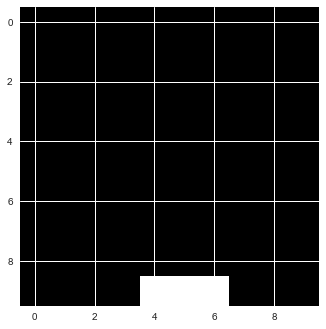

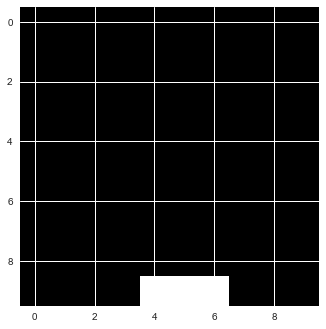

In [20]:
test(model)

## Evaluating progress

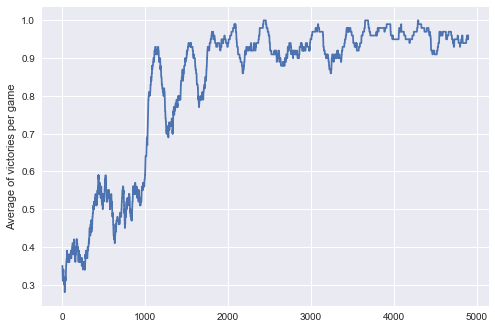

In [19]:
def moving_average_diff(a, n=100):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(hist))
plt.ylabel('Average of victories per game')
plt.show()

In [ ]:
£